# Identifying 2D Ising Model Phases with Logistic Regression

In this notebook we use the binary classification method logistic regression to predict if a given state of the two-dimensional Ising model is ordered or disordered. The data is a set of spin configurations labeled ordered 1 or disordered 0. The goal is to build a model which will take in a spin configuration and predict whether it constitutes an ordered or disordered phase. The lattices are represented as flattened arrays with $1\,600$ elements instead of a matrix of $40 \times 40$ elements. The dataset is first divided into three pieces, each consisting of either the ordered, disordered or "critical-like" phase. Next, we make training and test sets of the ordered and disordered phases. The remaining critical states will be used as held-out test data which the hope is that we will be able to make good extrapolated predictions on.

### Configure notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import pickle
import sklearn.metrics as skm
import urllib

from IPython.display import display
import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

# Import code from src
sys.path.insert(0, '../src/')
from logisticmodel import LogisticRegression
from project_tools import fig_path, tab_path, df_to_latex

# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


### Ising model parameters

In [2]:
np.random.seed(42) # shuffle random seed generator

# Ising model parameters
L = 40                          # linear system size
J = -1.0                        # Ising interaction
T = np.linspace(0.25, 4.0, 16)  # set of temperatures
T_c = 2.26                      # Onsager critical temperature in the TD limit

### Download data set

In [ ]:
# Run this cell to load data from web.
# Downloaded files will be stored locally, i.e. one run of this cell is enough
# Warning: data set is approx 2GB

url_main = "https://physics.bu.edu/~pankajm/ML-Review-Datasets/isingMC/"
data_file_name = "Ising2DFM_reSample_L40_T=All.pkl"
label_file_name = "Ising2DFM_reSample_L40_T=All_labels.pkl"

labels = pickle.load(urllib.request.urlopen(url_main + label_file_name))

data = pickle.load(urllib.request.urlopen(url_main + data_file_name))
data = np.unpackbits(data).reshape(-1, 1600)
data = data.astype('int')

np.save("labels", labels)
np.save("spin_data", data)

del data, labels

### Load data set

In [3]:
X = np.load("spin_data.npy")
y = np.load("labels.npy")

# Reduce precision
X = np.float32(X)
y = np.float32(y)

# divide data into ordered, critical and disordered
X_ordered = X[:70000,:]
y_ordered = y[:70000]

X_critical = X[70000:100000,:]
y_critical = y[70000:100000]

X_disordered = X[100000:,:]
y_disordered = y[100000:]

# define training and test data sets
X = np.concatenate((X_ordered, X_disordered))
y = np.concatenate((y_ordered, y_disordered))

### Plot a few Ising states

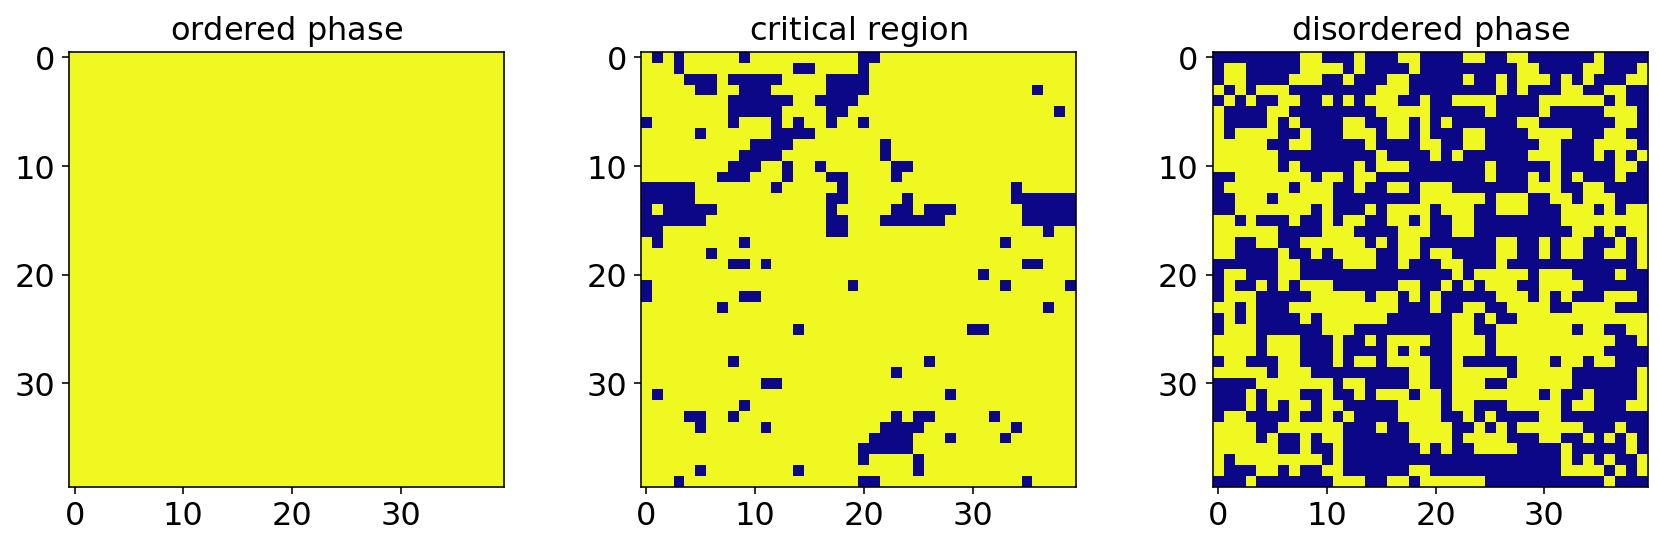

In [4]:
# set colourbar map
cmap_args = dict(cmap='plasma_r')

# plot states
fig, axarr = plt.subplots(nrows=1, ncols=3)

axarr[0].imshow(X_ordered[20001].reshape(L, L), **cmap_args)
axarr[0].set_title('$\\mathrm{ordered\\ phase}$', fontsize=16)
axarr[0].tick_params(labelsize=16)

axarr[1].imshow(X_critical[10001].reshape(L, L), **cmap_args)
axarr[1].set_title('$\\mathrm{critical\\ region}$', fontsize=16)
axarr[1].tick_params(labelsize=16)

im=axarr[2].imshow(X_disordered[50001].reshape(L,L),**cmap_args)
axarr[2].set_title('$\\mathrm{disordered\\ phase}$',fontsize=16)
axarr[2].tick_params(labelsize=16)

fig.subplots_adjust(right=2.0)

fig.savefig(fig_path("ising_states.pdf"), bbox_inches='tight')
plt.show()

# Train Classifier with Gradient Descent Method

### Try to find optimal parameters

First we try to find an optimal pair of the learning rate and regularization parameter with just 4% training data. 

X_train shape: (5200, 1600)
Y_train shape: (5200,)

5200 train samples
30000 critical samples
124800 test samples

Learning rate: 0.0001
Iteration no: 1/8
Iteration no: 2/8
Iteration no: 3/8
Iteration no: 4/8
Iteration no: 5/8
Iteration no: 6/8
Iteration no: 7/8
Iteration no: 8/8


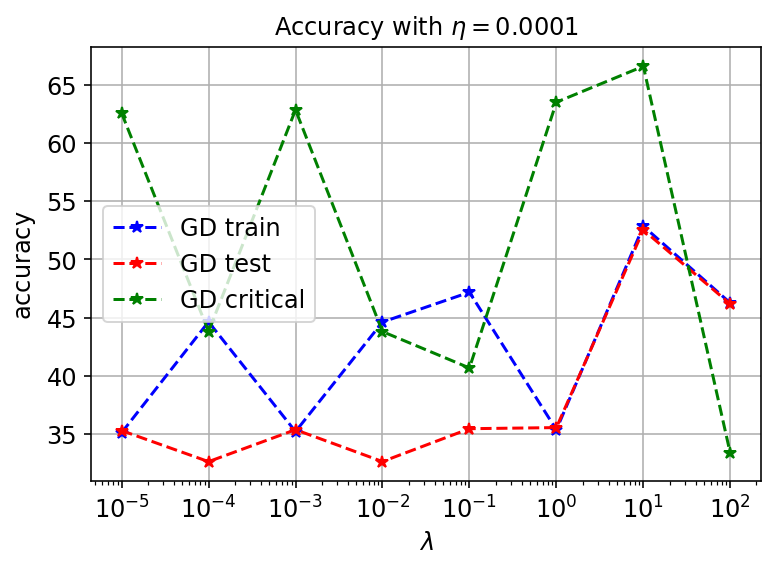

Learning rate: 0.001
Iteration no: 1/8
Iteration no: 2/8
Iteration no: 3/8
Iteration no: 4/8
Iteration no: 5/8
Iteration no: 6/8
Iteration no: 7/8
Iteration no: 8/8


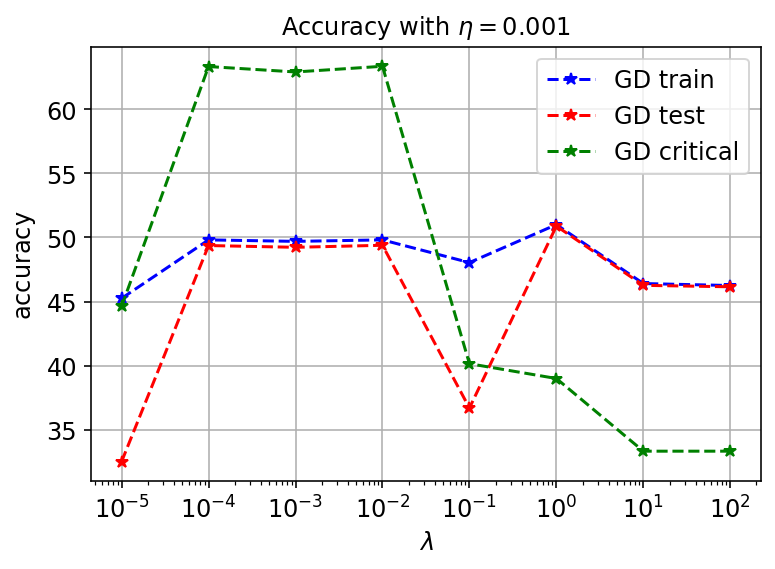

Learning rate: 0.01
Iteration no: 1/8
Iteration no: 2/8
Iteration no: 3/8
Iteration no: 4/8
Iteration no: 5/8
Iteration no: 6/8
Iteration no: 7/8
Iteration no: 8/8


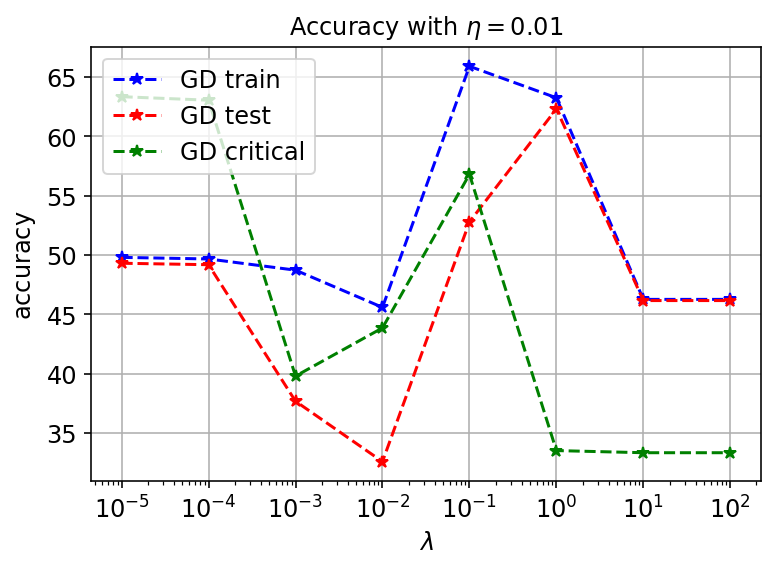

Learning rate: 0.1
Iteration no: 1/8
Iteration no: 2/8
Iteration no: 3/8
Iteration no: 4/8
Iteration no: 5/8
Iteration no: 6/8
Iteration no: 7/8
Iteration no: 8/8


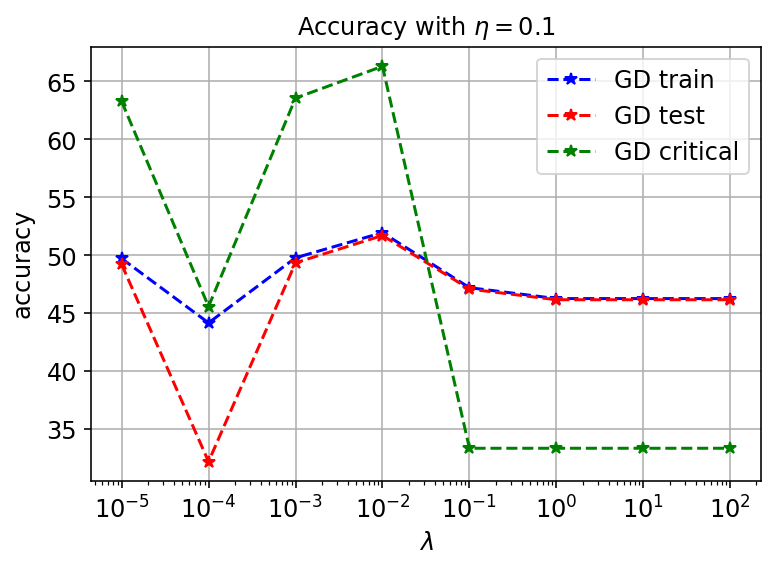

,$\eta$,$\lambda$,Training accuracy,Test accuracy,Critical accuracy
0,0.00010,0.00001,35.11538,35.29647,62.56333
1,0.00010,0.00010,44.63462,32.63061,43.80333
2,0.00010,0.00100,35.21154,35.37340,62.83333
3,0.00010,0.01000,44.61538,32.63702,43.79667
4,0.00010,0.10000,47.17308,35.45833,40.67333
5,0.00010,1.00000,35.36538,35.55369,63.49333
6,0.00010,10.00000,52.84615,52.51843,66.57667
7,0.00010,100.00000,46.25000,46.15865,33.33333
8,0.00100,0.00001,45.25000,32.51843,44.62333
9,0.00100,0.00010,49.80769,49.36699,63.32333


In [5]:
# Initialize instance
logreg = LogisticRegression()

# create the training and test sets
X_train, X_test, y_train, y_test = logreg.split_data(X, y, test_ratio=0.96)

print('X_train shape:', X_train.shape)
print('Y_train shape:', y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')
print()

# Dataframe for storing results
df = pd.DataFrame(columns=['$\eta$', '$\lambda$', 'Training accuracy', 'Test accuracy', 'Critical accuracy'])

lmbdas = np.logspace(-5, 2, 8)
etas = np.logspace(-4, -1, 4)

for eta in etas:
    print("Learning rate:", eta)
    
    train_accuracy_gd = np.zeros(lmbdas.shape,np.float64)
    test_accuracy_gd = np.zeros(lmbdas.shape,np.float64)
    critical_accuracy_gd = np.zeros(lmbdas.shape,np.float64)
    
    for i, lmbda in enumerate(lmbdas):
        print(f'Iteration no: {i + 1}/8')
        
        logreg.set_eta(eta)
        logreg.set_penalty(lmbda)
        logreg.fit(X_train, y_train)
        
        train_acc = logreg.accuracy(X_train, y_train)
        test_acc = logreg.accuracy(X_test, y_test)
        critical_acc = logreg.accuracy(X_critical, y_critical)
        
        # feed to arrays and df
        train_accuracy_gd[i] = train_acc
        test_accuracy_gd[i] = test_acc
        critical_accuracy_gd[i] = critical_acc
        
        df = df.append(
            {'$\eta$': eta,
             '$\lambda$': lmbda,
             'Training accuracy': train_acc,
             'Test accuracy': test_acc,
             'Critical accuracy': critical_acc},
            ignore_index=True
        )
        
    # Plot accuracy
    fig = plt.gcf()

    plt.semilogx(lmbdas,train_accuracy_gd,'*--b',label='GD train')
    plt.semilogx(lmbdas,test_accuracy_gd,'*--r',label='GD test')
    plt.semilogx(lmbdas,critical_accuracy_gd,'*--g',label='GD critical')

    plt.xlabel('$\\lambda$')
    plt.ylabel('$\\mathrm{accuracy}$')
    plt.title("Accuracy with $\eta=$" + str(eta))

    plt.grid()
    plt.legend()
    
    txt_eta = str(round(eta, 4)).replace(".", "_")
  
    fig.savefig(fig_path("log_acc_eta_{}.pdf".format(txt_eta)), bbox_inches='tight')
    plt.show()

# write to file
df_to_latex(df, "logreg_find_opt_params.tex")        
display(df) 

In [26]:
def latex_table(df, outfile):
    col_format = 2 * 'c'
    # Render dataframe to a LaTeX tabular environment table and write to file
    pd.options.display.float_format = '{:,.5f}'.format
    df = df.apply(lambda x: x.astype(
        int) if np.allclose(x, x.astype(int)) else x)
    pd.options.display.latex.escape = False
    latex = df.to_latex(index=True, column_format=col_format)
    latex = latex.replace('\\toprule', '\\hline \\hline')
    latex = latex.replace('\\midrule', '\\hline \\hline')
    latex = latex.replace('\\bottomrule', '\\hline \\hline')

    with open(tab_path(outfile), 'w') as f:
        f.write(latex)

# Display the highest accuracies
print("Max based on training accuracy")
df_train = df.loc[df['Training accuracy'].idxmax()].to_frame()
latex_table(df_train, "opt_params_train_max.tex") 
display(df_train)
print()

print("Max based on test accuracy")
df_test = df.loc[df['Test accuracy'].idxmax()].to_frame()
latex_table(df_test, "opt_params_test_max.tex") 
display(df_test)
print()

print("Max based on critical accuracy")
df_crit = df.loc[df['Critical accuracy'].idxmax()].to_frame()
latex_table(df_crit, "opt_params_crit_max.tex") 
display(df_crit)

Max based on training accuracy


,20
$\eta$,0.01000
$\lambda$,0.10000
Training accuracy,65.88462
Test accuracy,52.76923
Critical accuracy,56.78000



Max based on test accuracy


,21
$\eta$,0.01000
$\lambda$,1.00000
Training accuracy,63.23077
Test accuracy,62.29567
Critical accuracy,33.51333



Max based on critical accuracy


,6
$\eta$,0.00010
$\lambda$,10.00000
Training accuracy,52.84615
Test accuracy,52.51843
Critical accuracy,66.57667


### Train on larger data set with optimal (?) parameters 

There are no clear optimal parameters, and the accuracy with a particular set of parameters also changes for different runs. None of the best accuracies are great either. However, we stick with the best result for the training accuracy in the df above.

X_train shape: (26000, 1600)
Y_train shape: (26000,)

26000 train samples
30000 critical samples
104000 test samples

eta: 0.01
lambda: 0.1
Training accuracy 53.74230769230769
Test accuracy 53.61057692307693
Critical accuracy 66.66666666666666

LogisticRegression AUC (Train): 0.49668378262729995
LogisticRegression AUC (Test): 0.49662367358605164
LogisticRegression AUC (Critical): 0.5


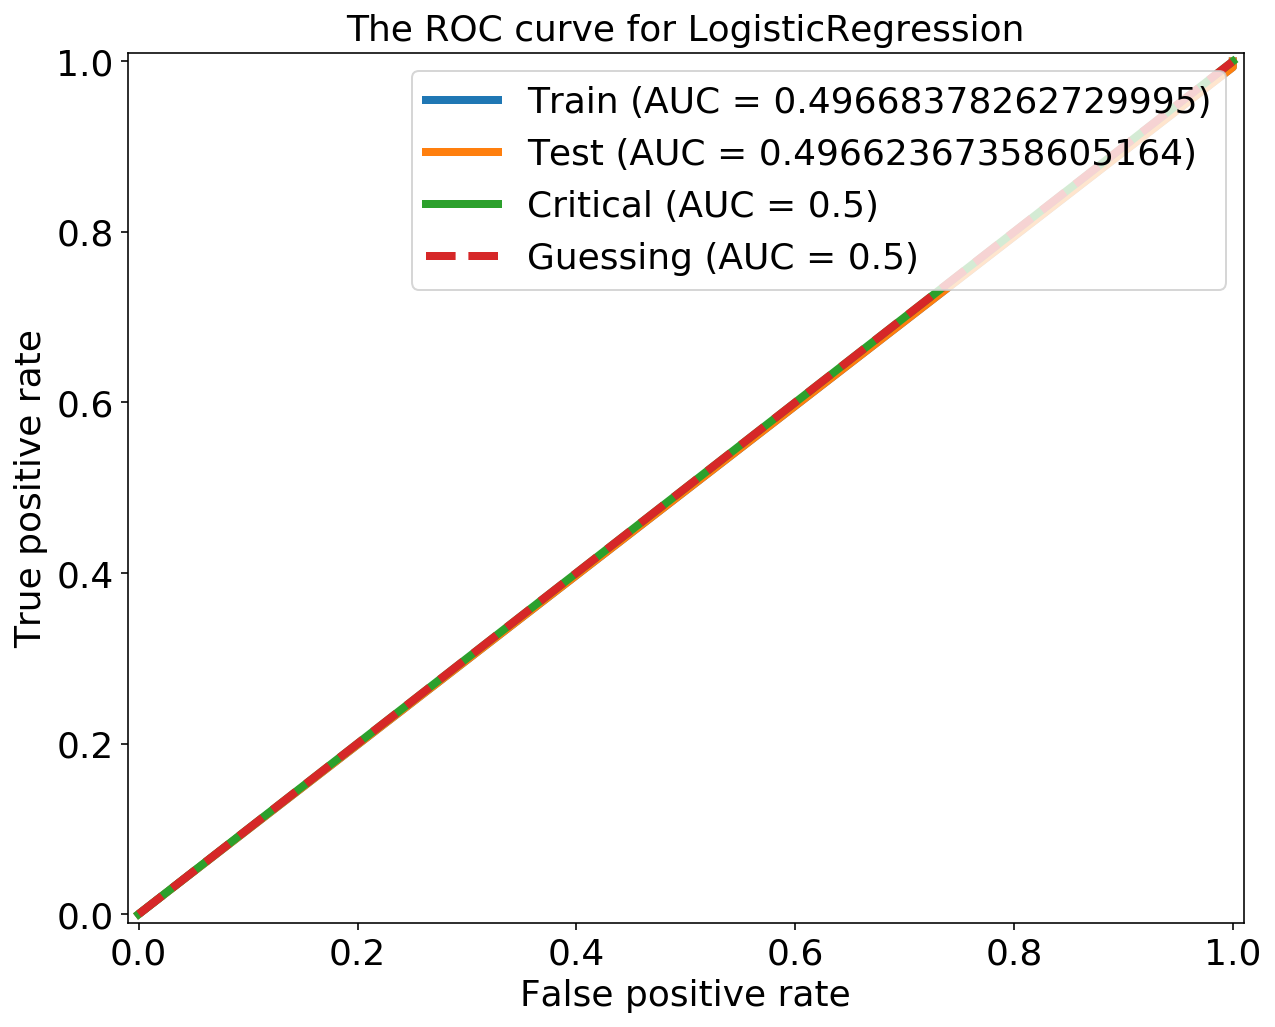

In [14]:
# Initialize instance
logreg2 = LogisticRegression()

# create the training and test sets
X_train, X_test, y_train, y_test = logreg2.split_data(X, y, test_ratio=0.8)

print('X_train shape:', X_train.shape)
print('Y_train shape:', y_train.shape)
print()
print(X_train.shape[0], 'train samples')
print(X_critical.shape[0], 'critical samples')
print(X_test.shape[0], 'test samples')
print()

# optimal parameters
eta = 0.01
lmbda = 0.1

logreg2.set_eta(eta)
logreg2.set_penalty(lmbda)
logreg2.fit(X_train, y_train)  

train_acc = logreg2.accuracy(X_train, y_train)
test_acc = logreg2.accuracy(X_test, y_test)
critical_acc = logreg2.accuracy(X_critical, y_critical)

print('eta:', eta)
print('lambda:', lmbda)
print('Training accuracy', train_acc)
print('Test accuracy', test_acc)
print('Critical accuracy', critical_acc)
print()

# ROC curve
fig = plt.figure(figsize=(10, 8))
for (_X, _y), label in zip([(X_train, y_train),(X_test, y_test), (X_critical, y_critical)], ["Train", "Test", "Critical"]):
    _X = np.c_[np.ones(_X.shape[0]), _X]
    proba = logreg2.predict_proba(_X)
    fpr, tpr, _ = skm.roc_curve(_y, proba)
    roc_auc = skm.auc(fpr, tpr)

    print ("LogisticRegression AUC ({0}): {1}".format(label, roc_auc))

    plt.plot(fpr, tpr, label="{0} (AUC = {1})".format(label, roc_auc), linewidth=4.0)

plt.plot([0, 1], [0, 1], "--", label="Guessing (AUC = 0.5)", linewidth=4.0)

plt.title(r"The ROC curve for LogisticRegression", fontsize=18)
plt.xlabel(r"False positive rate", fontsize=18)
plt.ylabel(r"True positive rate", fontsize=18)
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="best", fontsize=18)
fig.savefig(fig_path("logistic_roc_curve_gd.pdf"), bbox_inches='tight')
plt.show()

# Train Classifier with Newton-Raphson's Method

To conclude the logistic regression analysis, we try to use Newton-Raphson's method for optimization. Since inverting the Hessian matrix is a slow process and requires a lot of memory if we use lots of data, we use only 4 percent of the combination of disordered and ordered data for training. The 96 percent remaining data is used to estimate the test error to find the optimal value for $\lambda$. We train the model for $\lambda=0$ and for $\lambda=10^{-i}$ with $i=-5,-4,\ldots,2$. We do $10$ iterations of the Newton-Raphson method for each $\lambda$. This proved to be more than sufficient. We did not seem to get convergence for small $\lambda$, and hence we keep track of the value of the cost function at each step and stick with the weights that yielded the lowest value.

,$\lambda$,Training accuracy,Test accuracy,Critical accuracy
0,0.00001,95.09615,68.80849,53.51667
1,0.00010,95.09615,68.81090,53.52333
2,0.00100,95.05769,68.81330,53.51667
3,0.01000,94.92308,68.86779,53.69333
4,0.10000,93.59615,69.24038,54.26667
5,1.00000,90.44231,70.10497,56.50667
6,10.00000,86.88462,69.99679,60.48333
7,100.00000,82.38462,68.71715,64.17333


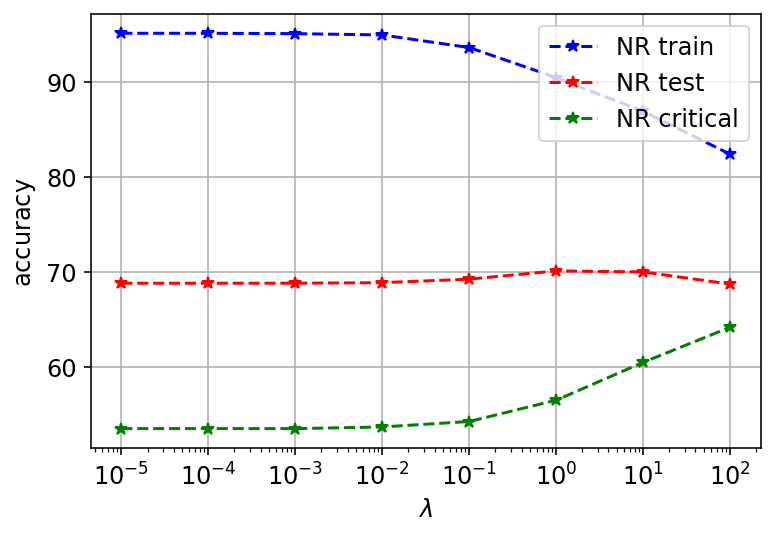

In [24]:
# Initialize instance, use only 1 iteration in order to keep track of the accuracy at each step
logreg_nr = LogisticRegression(n_iter=1)

# Use only 4 percent of the data in Newton-Raphson
X_train_nr, X_test_nr, y_train_nr, y_test_nr = logreg_nr.split_data(X, y, test_ratio=0.96)

lmbdas = np.logspace(-5, 2, 8)
train_accuracy_nr = np.zeros(lmbdas.shape,np.float64)
test_accuracy_nr = np.zeros(lmbdas.shape,np.float64)
critical_accuracy_nr = np.zeros(lmbdas.shape,np.float64)
weights_nr = []

for i, lmbda in enumerate(lmbdas):
        logreg_nr.set_penalty(lmbda)
        weights = np.zeros(X.shape[1] + 1)
        lowest_cost = np.inf
        optimal_weights = weights
        for j in range(10):
            weights = logreg_nr.fit(X_train_nr, y_train_nr, method='NR', weights=weights)
            cost = logreg_nr.cost() 
            if cost < lowest_cost:
                train_acc = logreg_nr.accuracy(X_train_nr, y_train_nr)
                test_acc = logreg_nr.accuracy(X_test_nr, y_test_nr)
                critical_acc = logreg_nr.accuracy(X_critical, y_critical)
                optimal_weights = weights
                
train_accuracy_nr[i] = train_acc
test_accuracy_nr[i] = test_acc
critical_accuracy_nr[i] = critical_acc
weights_nr.append(optimal_weights)

df_nr_accuracy = pd.DataFrame({'$\lambda$': lmbdas, 'Training accuracy': train_accuracy_nr, 'Test accuracy': test_accuracy_nr, 'Critical accuracy': critical_accuracy_nr})
latex_table(df_nr_accuracy, "nr_accuracy.tex") 
display(df_nr_accuracy)

# Plot accuracy
fig1 = plt.gcf()
plt.semilogx(lmbdas,train_accuracy_nr,'*--b',label='NR train')
plt.semilogx(lmbdas,test_accuracy_nr,'*--r',label='NR test')
plt.semilogx(lmbdas,critical_accuracy_nr,'*--g',label='NR critical')
plt.xlabel('$\\lambda$')
plt.ylabel('$\\mathrm{accuracy}$')
plt.grid()
plt.legend()
fig1.savefig(fig_path("log_acc_nr.pdf"), bbox_inches='tight')
plt.show()

We get a slight top at $\lambda = 10^0=1$, so this is our chosen $\lambda$. We plot the ROC curve with this regularization to evaluate the model.

LogisticRegression AUC (Train): 0.9562538477819325
LogisticRegression AUC (Test): 0.5019321436495388
LogisticRegression AUC (Critical): 0.5005399349999999


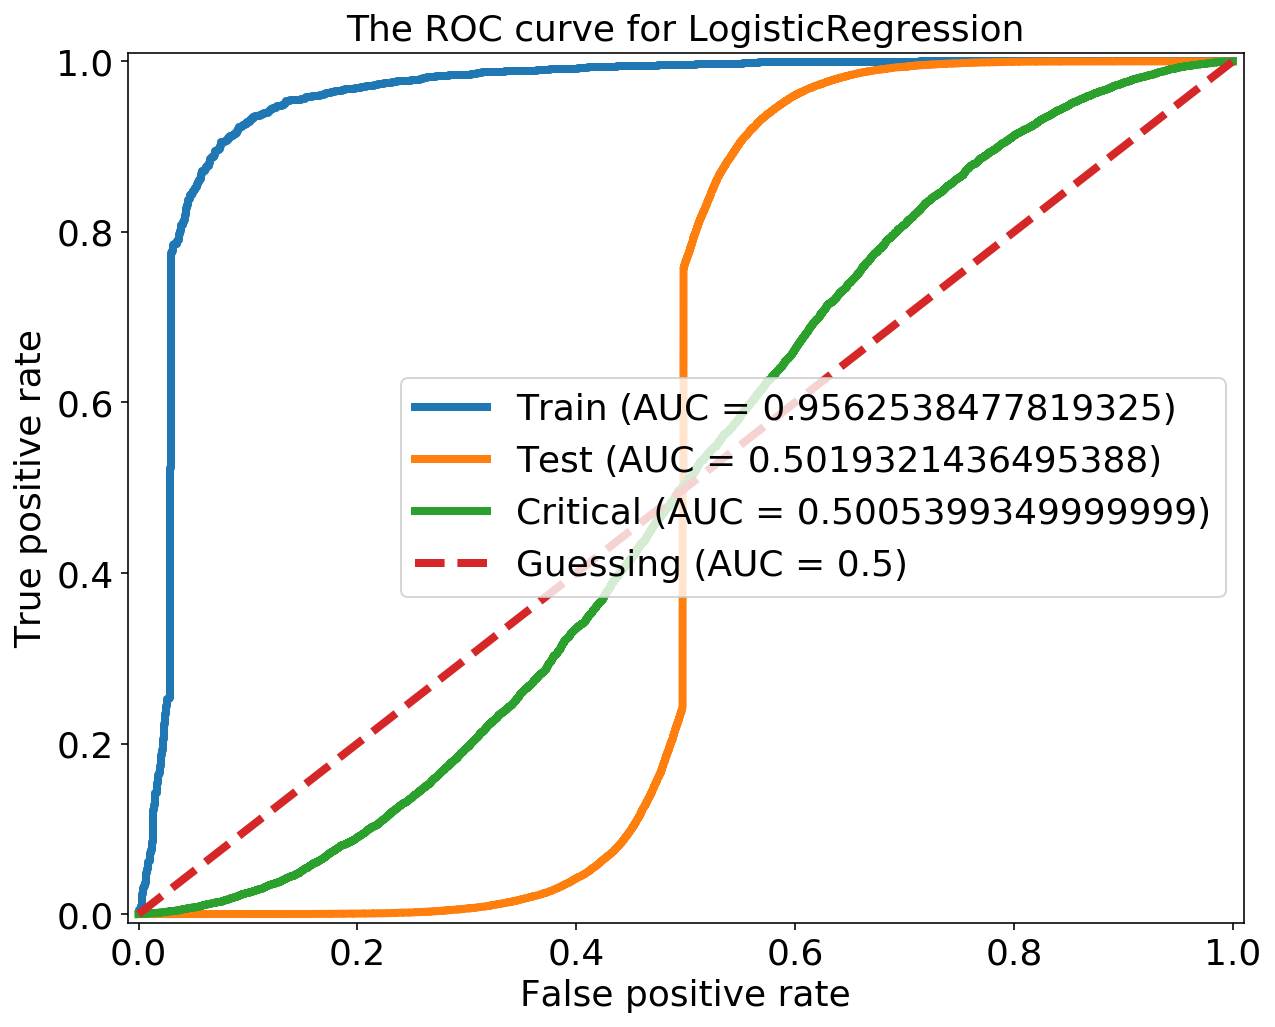

In [12]:
logreg_nr2 = LogisticRegression()
logreg_nr2._weights = weights_nr[5] # Weights found for lmbda = 1
fig2 = plt.figure(figsize=(10, 8))
for (_X, _y), label in zip([(X_train_nr, y_train_nr),(X_test_nr, y_test_nr), (X_critical, y_critical)], ["Train", "Test", "Critical"]):
    _X = np.c_[np.ones(_X.shape[0]), _X]
    proba = logreg_nr2.predict_proba(_X)
    fpr, tpr, _ = skm.roc_curve(_y, proba)
    roc_auc = skm.auc(fpr, tpr)

    print ("LogisticRegression AUC ({0}): {1}".format(label, roc_auc))

    plt.plot(fpr, tpr, label="{0} (AUC = {1})".format(label, roc_auc), linewidth=4.0)

plt.plot([0, 1], [0, 1], "--", label="Guessing (AUC = 0.5)", linewidth=4.0)
plt.title(r"The ROC curve for LogisticRegression", fontsize=18)
plt.xlabel(r"False positive rate", fontsize=18)
plt.ylabel(r"True positive rate", fontsize=18)
plt.axis([-0.01, 1.01, -0.01, 1.01])
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="best", fontsize=18)
fig2.savefig(fig_path("logistic_roc_curve_nr.pdf"), bbox_inches='tight')
plt.show()

# Conclusion 

Logistic regression is not able to correctly fit the Ising model as it is not a linear model, and is, in the case with both Gradient Descent and Newton-Raphson as optimization methods, no better than just guessing.